In [1]:
# import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from src.data.make_dataset import merge_data 
from src.features.build_features import features,split_data,feature_engineering, drop_unnecessary_ft, get_unnecessary_ft
from xgboost import XGBClassifier
pd.options.display.max_columns =70

# I. Import whole dataset

In [2]:
# merge the dataset at a whole (train, test & target data all together)
train_values = pd.read_csv('../data/external/train_values.csv', index_col='building_id')
train_target = pd.read_csv('../data/external/train_labels.csv', index_col='building_id')
test_values = pd.read_csv('../data/external/test_values.csv', index_col='building_id')

df=merge_data(train_values, train_target, test_values)
df=df.reset_index()
display(df)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3.0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2.0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3.0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2.0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347464,310028,4,605,3623,3,70,20,6,t,r,q,f,q,t,d,0,1,0,0,0,0,1,0,0,0,0,w,1,1,1,0,0,0,0,0,0,0,0,0,NaN
347465,663567,10,1407,11907,3,25,6,7,n,r,n,f,q,s,d,1,1,1,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,NaN
347466,1049160,22,1136,7712,1,50,3,3,t,r,n,f,j,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,NaN
347467,442785,6,1041,912,2,5,9,5,t,r,n,f,q,s,d,1,1,0,0,0,0,0,0,0,0,0,a,1,0,0,0,0,0,0,0,0,0,0,0,NaN


# II. Preprocess dataset

In [3]:
# apply features function where encoding, scaling and adding means of categorical features from above happens
df=features(df)

In [4]:
display(df)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
0,802906,6,487,12198,0.125,30,6,5,1,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,28830,8,900,2812,0.125,10,8,7,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,94947,21,363,8973,0.125,10,5,5,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,590882,22,418,10694,0.125,10,6,5,0,1,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,201944,11,131,1488,0.250,30,8,9,1,0,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347464,310028,4,605,3623,0.250,70,20,6,0,1,0,0,0,0,1,0,0,0,0,0.111111,1,1,0,0,0,0,0,0,0,0,0,NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
347465,663567,10,1407,11907,0.250,25,6,7,1,1,1,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
347466,1049160,22,1136,7712,0.000,50,3,3,0,1,0,0,0,0,1,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
347467,442785,6,1041,912,0.125,5,9,5,1,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0

# III. Feature Selection and Rebalancing

## Investigate Correlations 

<ipython-input-5-c3cbffdb7fa2>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


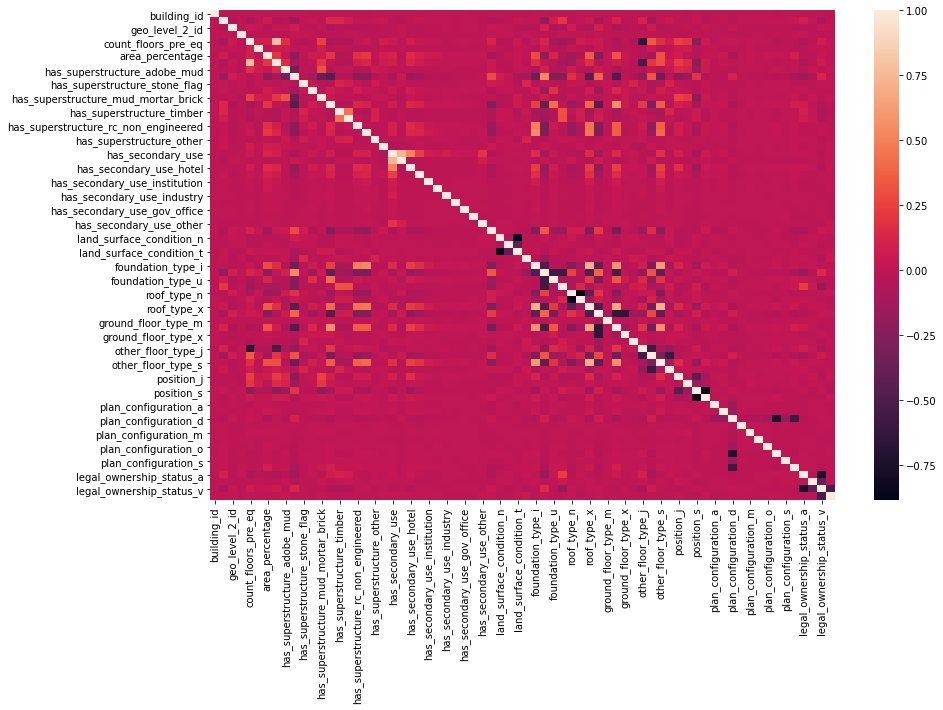

In [5]:
# investigate correlation heatmap
corrMatrix=df.corr()
f=plt.figure(figsize=(14,9))
sns.heatmap(corrMatrix, annot=False)
f.show()

In [6]:
# print all correlated features and drop them from the dataset
correlated_features = set()
correlation_matrix = df.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            print(f"The following features are correlated: {correlation_matrix.columns[i]} and {correlation_matrix.columns[j]}. Correlation = {round(abs(correlation_matrix.iloc[i, j]),2)}")
            colname = correlation_matrix.columns[i] # changed from i to j here for dropping
            correlated_features.add(colname)

#print(f"Drop the following features: {correlated_features}")
#df=df.drop(columns=correlated_features)

The following features are correlated: land_surface_condition_t and land_surface_condition_n. Correlation = 0.88
The following features are correlated: roof_type_q and roof_type_n. Correlation = 0.85
The following features are correlated: position_t and position_s. Correlation = 0.83


# IV. Split dataset back into train and test set


In [7]:
data_train, target_train, data_test = split_data(df)
data_train

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,0.125,30,6,5,1,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
28830,8,900,2812,0.125,10,8,7,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
94947,21,363,8973,0.125,10,5,5,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
590882,22,418,10694,0.125,10,6,5,0,1,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
201944,11,131,1488,0.250,30,8,9,1,0,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,25,1335,1621,0.000,55,6,3,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
669485,17,715,2060,0.125,0,6,5,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
602512,17,51,8163,0.250,55,6,7,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# V. Model building - Baselines

## Train-Test-Split

In [8]:
# train-test split with stratify
data_train, data_test, target_train, target_test = train_test_split(data_train, target_train, test_size=0.2, random_state=42, stratify=target_train)

In [9]:
#scale geo_features for logistic regression and runtime --> auch das schon vorher machen??? --> geo_level speichern???
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id','age']
geo_level_data_train =  data_train.copy()[geo_features]
scaler = MinMaxScaler()
data_train[geo_features] = scaler.fit_transform(data_train[geo_features])
data_train

<ipython-input-9-bbf7d2ee71ba>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train[geo_features] = scaler.fit_transform(data_train[geo_features])
C:\Users\luisa\anaconda3\envs\Quake\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
716310,0.700000,0.655221,0.474731,0.250,0.020101,6,6,0,1,0,0,0,0,1,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
283080,0.100000,0.861247,0.087465,0.125,0.020101,6,5,1,1,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
690774,0.700000,0.854240,0.215281,0.250,0.045226,6,5,0,1,0,0,0,0,0,0,0,0,0,0.444444,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
904803,0.666667,0.110722,0.195145,0.125,0.010050,7,5,0,0,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
991971,0.300000,0.469516,0.475686,0.125,0.000000,9,6,0,0,0,0,0,0,0,0,1,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819626,0.266667,0.829713,0.066057,0.000,0.010050,6,5,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
865223,0.133333,0.100911,0.457700,0.125,0.000000,8,4,0,1,0,0,0,0,1,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
363536,0.900000,0.384022,0.089057,0.250,0.020101,19,7,1,0,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [10]:
geo_level_data_train

,geo_level_1_id,geo_level_2_id,geo_level_3_id,age
building_id,,,,
716310,21,935,5965,20
283080,3,1229,1099,20
690774,21,1219,2705,45
904803,20,158,2452,10
991971,9,670,5977,0
...,...,...,...,...
819626,8,1184,830,10
865223,4,144,5751,0
363536,27,548,1119,20


## Rebalance Train Set

Text(0, 0.5, 'Frequency')

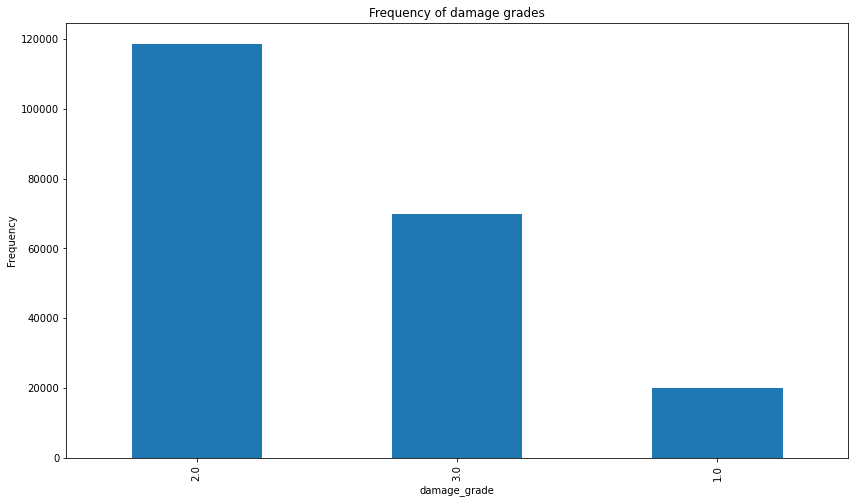

In [11]:
# investigate distribution of target variable
ax = target_train.value_counts().plot(kind='bar', figsize=(14,8), title="Frequency of damage grades")
ax.set_xlabel("damage_grade")
ax.set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

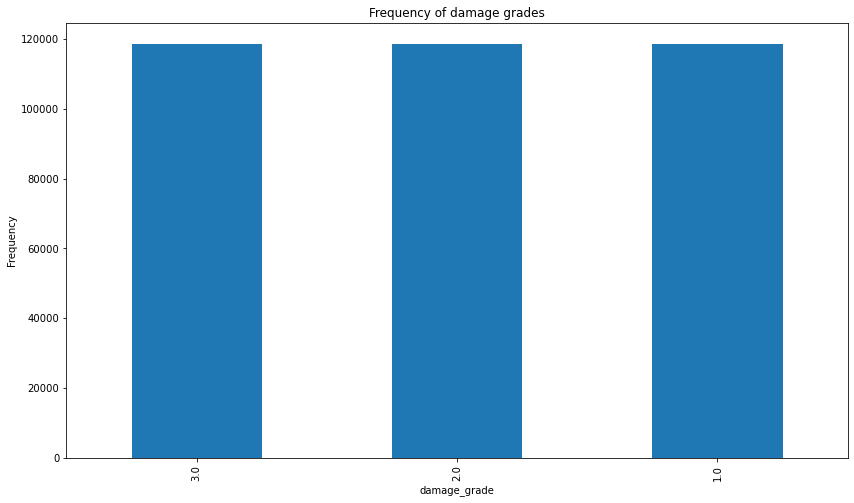

In [12]:
# choose to randomly oversample the train dataset as class 2 is highly over represented for our target variable damage grade
sampler = RandomOverSampler()
train_balanced_data, train_balanced_target = sampler.fit_resample(data_train, target_train)

ax = train_balanced_target.value_counts().plot(kind='bar', figsize=(14,8), title="Frequency of damage grades")
ax.set_xlabel("damage_grade")
ax.set_ylabel("Frequency")

In [13]:
train_balanced_data

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
0,0.700000,0.655221,0.474731,0.250,0.020101,6,6,0,1,0,0,0,0,1,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.100000,0.861247,0.087465,0.125,0.020101,6,5,1,1,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.700000,0.854240,0.215281,0.250,0.045226,6,5,0,1,0,0,0,0,0,0,0,0,0,0.444444,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.666667,0.110722,0.195145,0.125,0.010050,7,5,0,0,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.300000,0.469516,0.475686,0.125,0.000000,9,6,0,0,0,0,0,0,0,0,1,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355816,0.566667,0.920112,0.093991,0.250,0.035176,14,6,0,1,0,0,0,0,0,0,0,0,0,0.222222,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
355817,0.566667,0.160477,0.980342,0.125,0.005025,24,5,0,0,0,1,0,1,0,0,0,0,0,0.111111,1,0,1,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
355818,0.200000,0.878066,0.323359,0.250,0.025126,9,6,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
355819,0.333333,0.236160,0.549542,0.125,0.025126,7,4,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,

# Decision Tree

## ohne Rebalance

In [23]:
dt = DecisionTreeClassifier().fit(data_train,target_train)
prediction = dt.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.6585
The F1-Score micro on test set: 0.6585
The F1-Score macro on test set: 0.6107
The Precision-Score on test set: 0.6585
The Recall-Score on test set: 0.6585
Confusion Matrix : 
[[ 2608  2100   317]
 [ 2360 20898  6394]
 [  350  6277 10817]]


## mit Rebalance

In [24]:
dt = DecisionTreeClassifier().fit(train_balanced_data, train_balanced_target)
prediction = dt.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.6539
The F1-Score micro on test set: 0.6539
The F1-Score macro on test set: 0.6047
The Precision-Score on test set: 0.6539
The Recall-Score on test set: 0.6539
Confusion Matrix : 
[[ 2514  2214   297]
 [ 2311 20769  6572]
 [  319  6325 10800]]


# Logistic Regression

## ohne Rebalance

In [25]:
lr = LogisticRegression(max_iter=10000).fit(data_train, target_train)
prediction = lr.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.6723
The F1-Score micro on test set: 0.6723
The F1-Score macro on test set: 0.5840
The Precision-Score on test set: 0.6723
The Recall-Score on test set: 0.6723
Confusion Matrix : 
[[ 1675  3273    77]
 [ 1063 24558  4031]
 [   58  8580  8806]]


## mit Rebalance

In [26]:
lr = LogisticRegression(max_iter=10000).fit(train_balanced_data, train_balanced_target)
prediction = lr.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))

The Accuracy on test set: 0.6037
The F1-Score micro on test set: 0.6037
The F1-Score macro on test set: 0.5788
The Precision-Score on test set: 0.6037
The Recall-Score on test set: 0.6037


# SVM

### ohne Rebalance

In [ ]:
# sv = SVC(C=1, kernel ='rbf',decision_function_shape='ovo').fit(data_train, target_train)
# prediction = sv.predict(data_test)
# acc = accuracy_score(target_test,prediction) 
# f1_mic= f1_score(target_test,prediction,average='micro') 
# f1_mac= f1_score(target_test,prediction,average='macro') 
# pr= precision_score(target_test,prediction,average='micro') 
# re= recall_score(target_test,prediction,average='micro') 
# print("The Accuracy on test set: {:.4f}".format(acc))
# print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
# print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
# print("The Precision-Score on test set: {:.4f}".format(pr))
# print("The Recall-Score on test set: {:.4f}".format(re))
# print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

## mit Relabance

In [ ]:
# sv = SVC(C=1, kernel ='rbf',decision_function_shape='ovo').fit(train_balanced_data, train_balanced_target)
# prediction = sv.predict(data_test)
# acc = accuracy_score(target_test,prediction) 
# f1_mic= f1_score(target_test,prediction,average='micro') 
# f1_mac= f1_score(target_test,prediction,average='macro') 
# pr= precision_score(target_test,prediction,average='micro') 
# re= recall_score(target_test,prediction,average='micro') 
# print("The Accuracy on test set: {:.4f}".format(acc))
# print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
# print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
# print("The Precision-Score on test set: {:.4f}".format(pr))
# print("The Recall-Score on test set: {:.4f}".format(re))
# print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

# MISSING: Baseline Model XGBoost, Baseline Model Random Forest, in final -> evaluate with cross_validation

## --> Result: Performance is better without balancing! We will continue without it

# VI. Feature Engineering: Generate new Features

In [14]:
data_train[geo_features] = geo_level_data_train # reset geo_levels -> have to change afterwards again!
df=merge_data(data_train, target_train, data_test)
df=df.reset_index()
pd.set_option('display.max_columns', None)

display(df)
df = feature_engineering(df,4) # second parameter indicates whether to use 3 or 4 geo_level_1 districts
display(df)

C:\Users\luisa\anaconda3\envs\Quake\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,damage_grade
0,716310,21,935,5965,0.250,20,6,6,0,1,0,0,0,0,1,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
1,283080,3,1229,1099,0.125,20,6,5,1,1,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
2,690774,21,1219,2705,0.250,45,6,5,0,1,0,0,0,0,0,0,0,0,0,0.444444,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
3,904803,20,158,2452,0.125,10,7,5,0,0,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
4,991971,9,670,5977,0.125,0,9,6,0,0,0,0,0,0,0,0,1,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,689970,4,334,9226,0.250,10,6,7,0,1,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN
260597,1035221,8,145,9862,0.125,0,10,5,0,1,0,0,0,0,0,0,0,0,0,0.111111,1,0,1,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN
260598,1049706,25,725,5436,0.125,20,8,5,1,1,0,0,1,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN
260599,23598,5,601,3024,0.125,35,6,4,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.

,building_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,damage_grade,district_class_2,district_class_1,district_class_3,district_class_4,age_u_40,age_40_100,age_ue_100,low_mortar_percentage,high_mortar_percentage,low_percentage_r,high_percentage_r,fragile,stable,ft_imp_1_pos,ft_high_imp_1_pos,ft_imp_1_neg,area_vs_height,family_vs_area,dens_1,dens_2,dens_3,geo_level_1_id_0,geo_level_1_id_1,geo_level_1_id_2,geo_level_1_id_3,geo_level_1_id_4,geo_level_1_id_5,geo_level_1_id_6,geo_level_1_id_7,geo_level_1_id_8,geo_level_1_id_9,geo_level_1_id_10,geo_level_1_id_11,geo_level_1_id_12,geo_level_1_id_13,geo_level_1_id_14,geo_level_1_id_15,geo_level_1_id_16,geo_level_1_id_17,geo_level_1_id_18,geo_level_1_id_19,geo_level_1_id_20,geo_level_1_id_21,geo_level_1_id_22,geo_level_1_id_23,geo_level_1_id_24,geo_level_1_id_25,geo_level_1_id_26,geo_level_1_id_27,geo_level_1_id_28,geo_level_1_id_29,geo_level_1_id_30,age_0,age_5,age_10,age_15,age_20,age_25,age_30,age_35,age_40,age_45,age_50,age_55,age_60,age_65,age_70,age_75,age_80,age_85,age_90,age_95,age_100,age_105,age_110,age_115,age_120,age_125,age_130,age_135,age_140,age_145,age_150,age_155,age_160,age_165,age_170,age_175,age_180,age_185,age_190,age_195,age_200,age_995
0,716310,0.655221,0.474656,0.250,0.050505,0.133333,0,1,0,0,0,0,1,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,1,0,1,1.0,0.0,0.0,0.0,1.0,0.030801,0.066667,0.606402,0.099083,0.052308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,283080,0.861247,0.087451,0.125,0.050505,0.100000,1,1,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,1,1.0,0.0,0.0,0.0,1.0,0.037372,0.066667,0.301667,0.253406,0.120000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,690774,0.854240,0.215246,0.250,0.05050

In [15]:
display(get_unnecessary_ft(df))
df = drop_unnecessary_ft(df)

['has_secondary_use_institution',
 'has_secondary_use_school',
 'has_secondary_use_industry',
 'has_secondary_use_health_post',
 'has_secondary_use_gov_office',
 'has_secondary_use_use_police',
 'has_secondary_use_other',
 'ground_floor_type_m',
 'ground_floor_type_z',
 'plan_configuration_a',
 'plan_configuration_c',
 'plan_configuration_f',
 'plan_configuration_m',
 'plan_configuration_n',
 'plan_configuration_o',
 'plan_configuration_s',
 'legal_ownership_status_r',
 'geo_level_1_id_2',
 'geo_level_1_id_14',
 'geo_level_1_id_19',
 'geo_level_1_id_23',
 'geo_level_1_id_28',
 'geo_level_1_id_29',
 'age_55',
 'age_65',
 'age_70',
 'age_75',
 'age_85',
 'age_90',
 'age_95',
 'age_100',
 'age_105',
 'age_110',
 'age_115',
 'age_120',
 'age_125',
 'age_130',
 'age_135',
 'age_140',
 'age_145',
 'age_150',
 'age_155',
 'age_160',
 'age_165',
 'age_170',
 'age_175',
 'age_180',
 'age_185',
 'age_190',
 'age_195',
 'age_200',
 'age_995']

## State of the art -Modell

In [16]:
#Korrelation
correlated_features = set()
correlation_matrix = df.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            print(f"The following features are correlated: {correlation_matrix.columns[i]} and {correlation_matrix.columns[j]}. Correlation = {round(abs(correlation_matrix.iloc[i, j]),2)}")
            colname = correlation_matrix.columns[j]
            correlated_features.add(colname)
print(f"Drop the following features: {correlated_features}")
#drop correlated features
df=df.drop(columns=correlated_features)

The following features are correlated: land_surface_condition_t and land_surface_condition_n. Correlation = 0.88
The following features are correlated: roof_type_q and roof_type_n. Correlation = 0.85
The following features are correlated: position_t and position_s. Correlation = 0.82
The following features are correlated: age_40_100 and age_u_40. Correlation = 0.96
The following features are correlated: high_mortar_percentage and low_mortar_percentage. Correlation = 1.0
The following features are correlated: high_percentage_r and low_percentage_r. Correlation = 1.0
The following features are correlated: ft_high_imp_1_pos and stable. Correlation = 0.9
The following features are correlated: ft_imp_1_neg and roof_type_x. Correlation = 0.84
The following features are correlated: ft_imp_1_neg and fragile. Correlation = 0.84
Drop the following features: {'age_u_40', 'stable', 'roof_type_x', 'low_percentage_r', 'land_surface_condition_n', 'low_mortar_percentage', 'position_s', 'fragile', 'roo

In [17]:
train_data, train_target, test_data = split_data(df)
train_data

,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_q,ground_floor_type_f,ground_floor_type_v,ground_floor_type_x,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_t,plan_configuration_d,plan_configuration_q,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_v,legal_ownership_status_w,district_class_2,district_class_1,district_class_3,district_class_4,age_40_100,age_ue_100,high_mortar_percentage,high_percentage_r,ft_imp_1_pos,ft_high_imp_1_pos,ft_imp_1_neg,area_vs_height,family_vs_area,dens_1,dens_2,dens_3,geo_level_1_id_0,geo_level_1_id_1,geo_level_1_id_3,geo_level_1_id_4,geo_level_1_id_5,geo_level_1_id_6,geo_level_1_id_7,geo_level_1_id_8,geo_level_1_id_9,geo_level_1_id_10,geo_level_1_id_11,geo_level_1_id_12,geo_level_1_id_13,geo_level_1_id_15,geo_level_1_id_16,geo_level_1_id_17,geo_level_1_id_18,geo_level_1_id_20,geo_level_1_id_21,geo_level_1_id_22,geo_level_1_id_24,geo_level_1_id_25,geo_level_1_id_26,geo_level_1_id_27,geo_level_1_id_30,age_0,age_5,age_10,age_15,age_20,age_25,age_30,age_35,age_40,age_45,age_50,age_60,age_80
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
716310,0.655221,0.474656,0.250,0.050505,0.133333,0,1,0,0,0,0,1,0,0,0,0,0.111111,0,0,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.0,0.0,1.0,0.030801,0.066667,0.606402,0.099083,0.052308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
283080,0.861247,0.087451,0.125,0.050505,0.100000,1,1,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.0,0.0,1.0,0.037372,0.066667,0.301667,0.253406,0.120000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
690774,0.854240,0.215246,0.250,0.050505,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.444444,0,0,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1,1,0.0,0.0,1.0,0.037372,0.266667,0.606402,0.090661,0.067692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
904803,0.110722,0.195114,0.125,0.060606,0.100000,0,0,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1.0,0.0,1.0,0.043943,0.057143,0.702894,0.623978,0.535385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
991971,0.469516,0.475611,0.125,0.080808,0.133333,0,0,0,0,0,0,0,0,1,0,0,0.111111,0,0,0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0,1.0,0.0,0.047228,0.044444,0.153135,0.100322,0.067692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,

In [18]:
data_train, data_test, target_train, target_test = train_test_split(train_data, train_target, test_size=0.2, random_state=42, stratify=train_target)

In [19]:
model = XGBClassifier(use_label_encoder = True, max_depth=10,verbosity=2)
model.fit(data_train, target_train)
pred = model.predict(data_test)

acc = accuracy_score(target_test, pred)
f1_mic = f1_score(target_test, pred, average='micro')
f1_mac = f1_score(target_test, pred, average='macro')
print('The Accuracy is:{:,.4f}'.format(acc))
print('The f1_mic is:{:,.4f}'.format(f1_mic))
print('The f1_mac is:{:,.4f}'.format(f1_mac))

C:\Users\luisa\anaconda3\envs\Quake\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:02] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 1324 extra nodes, 0 pruned nodes, max_depth=10
[18:58:03] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 1180 extra nodes, 0 pruned nodes, max_depth=10
[18:58:03] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 1196 extra nodes, 0 pruned nodes, max_depth=10
[18:58:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:04] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 1262 extra nodes, 0 pruned nodes, max_depth=10
[18:58:04] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 1190 extra nodes, 0 pruned nodes, max_depth=10
[18:58:05] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 1198 extra nodes, 0 pruned nodes, max_depth=10
[18:58:06] INFO: ..\src\tree\updater_prune.cc:101: 

[18:58:42] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 730 extra nodes, 0 pruned nodes, max_depth=10
[18:58:43] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 966 extra nodes, 0 pruned nodes, max_depth=10
[18:58:43] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 490 extra nodes, 0 pruned nodes, max_depth=10
[18:58:44] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 748 extra nodes, 0 pruned nodes, max_depth=10
[18:58:44] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 678 extra nodes, 0 pruned nodes, max_depth=10
[18:58:45] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 680 extra nodes, 0 pruned nodes, max_depth=10
[18:58:45] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 694 extra nodes, 0 pruned nodes, max_depth=10
[18:58:46] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 1000 extra nodes, 0 pruned nodes, max_depth=10
[18:58:46] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 734 extra 

[18:59:21] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=10
[18:59:22] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 850 extra nodes, 0 pruned nodes, max_depth=10
[18:59:22] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 556 extra nodes, 0 pruned nodes, max_depth=10
[18:59:23] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 330 extra nodes, 0 pruned nodes, max_depth=10
[18:59:23] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 606 extra nodes, 0 pruned nodes, max_depth=10
[18:59:24] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 758 extra nodes, 0 pruned nodes, max_depth=10
[18:59:25] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 340 extra nodes, 0 pruned nodes, max_depth=10
[18:59:26] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 610 extra nodes, 0 pruned nodes, max_depth=10
[18:59:27] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 804 extra n

[19:00:06] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 406 extra nodes, 0 pruned nodes, max_depth=10
[19:00:07] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 686 extra nodes, 0 pruned nodes, max_depth=10
[19:00:08] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 552 extra nodes, 0 pruned nodes, max_depth=10
[19:00:08] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 470 extra nodes, 0 pruned nodes, max_depth=10
[19:00:09] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 144 extra nodes, 0 pruned nodes, max_depth=10
[19:00:09] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 536 extra nodes, 0 pruned nodes, max_depth=10
[19:00:10] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 332 extra nodes, 0 pruned nodes, max_depth=10
[19:00:11] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 460 extra nodes, 0 pruned nodes, max_depth=10
[19:00:11] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 942 extra n

[19:00:47] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 426 extra nodes, 0 pruned nodes, max_depth=10
[19:00:48] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 194 extra nodes, 0 pruned nodes, max_depth=10
[19:00:48] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 482 extra nodes, 0 pruned nodes, max_depth=10
[19:00:49] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 370 extra nodes, 0 pruned nodes, max_depth=10
[19:00:49] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 574 extra nodes, 0 pruned nodes, max_depth=10
[19:00:50] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 418 extra nodes, 0 pruned nodes, max_depth=10
[19:00:51] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 544 extra nodes, 0 pruned nodes, max_depth=10
[19:00:51] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 546 extra nodes, 0 pruned nodes, max_depth=10
[19:00:52] INFO: ..\src\tree\updater_prune.cc:101: tree pruning end, 592 extra n

# VII. Engineered Models without Hyperparameter Tuning

## Decision Tree ohne Rebalance

In [ ]:
dt = DecisionTreeClassifier().fit(data_train,target_train)
prediction = dt.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

## Decision Tree mit Rebalance

In [ ]:
dt = DecisionTreeClassifier().fit(train_balanced_data, train_balanced_target)
prediction = dt.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

## Logistic Regressin ohne Rebalance

In [ ]:
lr = LogisticRegression(max_iter=10000).fit(data_train, target_train)
prediction = lr.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

## Logistic Regressin mit Rebalance

In [ ]:
lr = LogisticRegression(max_iter=10000).fit(train_balanced_data, train_balanced_target)
prediction = lr.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))

## xgboost ohne Rebalance

In [ ]:
xgb = XGBClassifier(use_label_encoder = True).fit(data_train, target_train)
prediction = xgb.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
#0,7397

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
# cross-validation
xgbm = XGBClassifier()
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgb, data_train, target_train, cv=kfold, scoring='f1_micro')
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

In [ ]:
# A parameter grid for XGBoost
random_grid = {
        'n_estimators': [50, 100, 150, 200],
        'min_child_weight': [4,5,6,7],
        'gamma': [i/10.0 for i in range(3)],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [i/10.0 for i in range(1, 3)],
        'max_depth': range(3, 10),
        'learning_rate': [0.01, 0.1, 0.2, 0.3]
        }

In [ ]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# xgbm = XGBClassifier()
# # Random search of parameters, using 3 fold cross validation, search across 100 different combinations
# rf_random = GridSearchCV(xgbm, random_grid, n_jobs=5, 
#                    cv=5, 
#                    scoring='f1_micro',
#                    verbose=2, refit=True)
# # Fit the random search model
# rf_random.fit(data_train, target_train)

In [ ]:
# best_random = rf_random.best_estimator_
# best_random.fit(data_train, target_train)
# prediction = best_random.predict(data_test)
# acc = accuracy_score(target_test,prediction) 
# f1_mic= f1_score(target_test,prediction,average='micro') 
# f1_mac= f1_score(target_test,prediction,average='macro') 
# pr= precision_score(target_test,prediction,average='micro') 
# re= recall_score(target_test,prediction,average='micro') 
# print("The Accuracy on test set: {:.4f}".format(acc))
# print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
# print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
# print("The Precision-Score on test set: {:.4f}".format(pr))
# print("The Recall-Score on test set: {:.4f}".format(re))

## hyperparameter

In [ ]:
#grid for xgboost
# Create the random grid
random_grid= {'min_child_weight':[ 4,5,6,7 ], 
              'gamma':[i/10.0 for i in range(1,4)],  
              'subsample':[1],
              'colsample_bytree':[1],
              'max_depth': [8]}

In [ ]:
# Use the random grid to search for best hyperparameters
from sklearn.model_selection import RandomizedSearchCV
# First create the base model to tune
xgbm = XGBClassifier()
# Random search of parameters, using 3 fold cross validation, search across 100 different combinations
rf_random = RandomizedSearchCV(estimator=xgbm, param_distributions=random_grid, n_iter=30, cv=5, verbose=2, random_state=42,scoring='f1_micro')
# Fit the random search model
rf_random.fit(data_train, target_train)

In [ ]:
best_random = rf_random.best_estimator_
best_random.fit(data_train, target_train)
prediction = best_random.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))

In [ ]:
rf_random.best_estimator_